In [1]:
import numpy as np
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import (StreamPowerEroder, LinearDiffuser, FlowAccumulator,#LithoLayers,
NormalFault, ChannelProfiler, ChiFinder, SteepnessFinder)
from landlab import imshow_grid
from matplotlib import pyplot as plt

In [2]:
# Add an elevation field 

# number_of_rows = 200            
# number_of_columns = 200        
dxy = 100 

# mg = RasterModelGrid((number_of_rows, number_of_columns), dxy)

# # Create random noise
# np.random.seed(0)                                       # seed set to zero so our figures are reproducible
# mg_noise = np.random.rand(mg.number_of_nodes)/1000.     # intial noise on elevation grid

# # set up the elevation on the grid
# zr = mg.add_zeros('node', 'topographic__elevation')
# zr += mg_noise

# import from netnc4
from landlab.io.netcdf import read_netcdf
mg = read_netcdf('test.nc', name='topographic__elevation')
list(mg.at_node.keys())
zr = mg.at_node['topographic__elevation']


In [3]:
# BC
East = 4
North = 4
West = 4
South = 1

mg.set_status_at_node_on_edges(right=East, top=North, left=West, bottom=South)

In [4]:
U = 1e-3
uplift_rate = np.ones(mg.number_of_nodes)*U
## One-time uplift event
#fault_location = 10000  # [m] (original value = 4000)
#uplift_amount = 100 # [m] (original value = 10)
#zr[np.where(mg.node_y>fault_location)] += uplift_amount 

## Continuously-slipping fault, 
#fault_location = 10000  # [m] (Original value = 4000)
#low_uplift_rate = 1E-3 # [m/yr] (Original value = 0.0001)
#high_uplift_rate = 1E-2 # [m/yr] (Original value = 0.0004)
#uplift_rate[np.where(mg.node_y<fault_location)] = low_uplift_rate
#uplift_rate[np.where(mg.node_y>fault_location)] = high_uplift_rate

## Uplift Gradient
#low_uplift_rate = 0.0001 # [m/yr]
#high_uplift_rate = 0.004 # [m/yr]
#uplift_rate_gradient = (high_uplift_rate - low_uplift_rate)/(number_of_rows-3)
#uplift_rate = low_uplift_rate + ((mg.node_y / dxy)-1) * uplift_rate_gradient
#normal fault

In [5]:

dt = 1000            # time step [yr]
tmax = 1E5+1        # time for the model loop to run [yr]
total_time = 0 
t = np.arange(0, tmax, dt)

In [6]:
# Set the parameter values for  the NormalFault compoent
# param_dict = {'faulted_surface': 'topographic__elevation',
#              'fault_dip_angle': 90.0,
#              'fault_throw_rate_through_time': {'time': [0, 50000, tmax],
#                                                'rate': [0.001, 0.001 , 0.001]},
#              'fault_trace': {'y1':5000,
#                             'x1': 0,
#                             'y2': 5000,
#                             'x2': 20000}, 
#              'include_boundaries': False}
# ft = NormalFault(mg, **param_dict)
# ft.faulted_nodes.reshape(mg.shape)
# ft.run_one_step(dt)  

# ids = np.array([[1]*int(mg.shape[0]/2.0) +[2]*int(mg.shape[0]/2.0)]*mg.shape[0])
# z0s = np.array([[1]*mg.shape[0]]*mg.shape[0])
# attrs = {'K_sp': {1: 1e-3, 2: 1e-4}}
#lith = Lithology(mg, thicknesses, ids, attrs)

# lith = LithoLayers(mg, z0s, ids, attrs)


In [7]:
## min_drainage_area = 1000
K_hs = 1E-3
#Ksp = 1E-4
m_sp = 0.5                  # exponent on drainage area in stream power equation 
n_sp = 1                    # exponent on slope in stream power equation
theta = m_sp / n_sp


#setting up lithology
Ksp = np.ones(mg.number_of_nodes)
Ksp [np.where(mg.node_y>10000)] = 1e-4
Ksp [np.where(mg.node_y<= 10000)] = 0.5e-3



frr = FlowAccumulator(mg) 
#spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
spr = StreamPowerEroder(mg, K_sp=Ksp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False)

# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg,reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg, min_drainage_area=1000.0,
               reference_concavity= theta,
               use_true_dx=True)


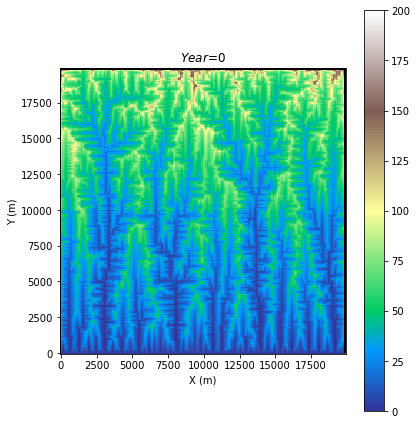

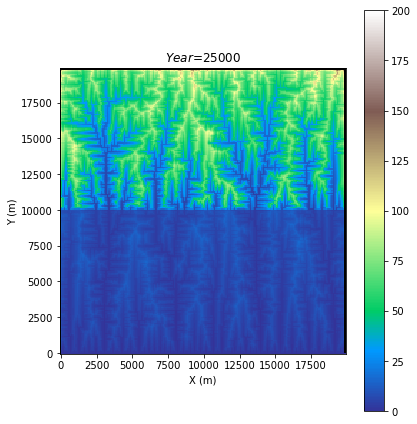

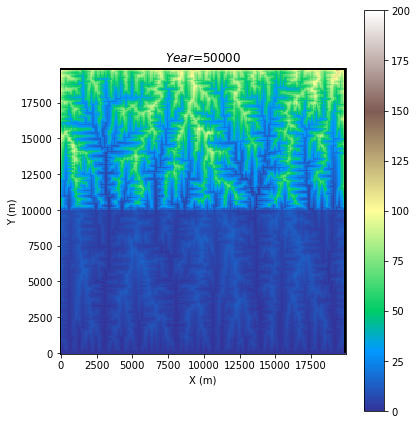

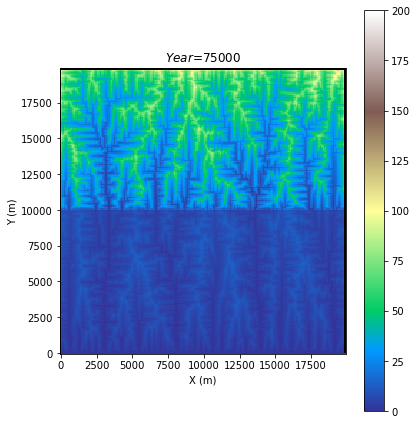

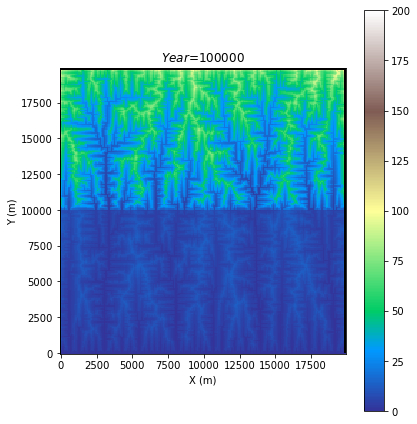

In [8]:
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision

#set up rate of fault propagation
    df = 0.5e-1
#set the fault parameter
#     param_dict = {'faulted_surface': 'topographic__elevation',
#                  'fault_dip_angle': 90.0,
#                  'fault_throw_rate_through_time': {'time': [0, tmax],
#                                                    'rate': [1e-4, 1e-4]},
#                  'fault_trace': {'y1':0, 
#                                 'x1': 10000+ df*total_time,
#                                 'y2': 7500, 
#                                 'x2': 10000+ df*total_time}, 
#                 'include_boundaries': False}
    
# static    
#     param_dict = {'faulted_surface': 'topographic__elevation',
#                  'fault_dip_angle': 90.0,
#                  'fault_throw_rate_through_time': {'time': [0, tmax],
#                                                    'rate': [1e-4, 1e-4]},
#                  'fault_trace': {'y1':0, 
#                                 'x1': 10000,
#                                 'y2': 20000, 
#                                 'x2': 10000}, 
#                 'include_boundaries': False}
#
# horizontal fault 
#     param_dict = {'faulted_surface': 'topographic__elevation',
#                  'fault_dip_angle': 90.0,
#                  'fault_throw_rate_through_time': {'time': [0,  tmax],
#                                                    'rate': [1e-3,  1e-3]},
#                  'fault_trace': {'y1':7500+ df*total_time, 
#                                 'x1': 0,
#                                 'y2': 7500+ df*total_time, 
#                                 'x2': 20000}, 
#                  'include_boundaries': False}

#     ft = NormalFault(mg, **param_dict)
#     ft.faulted_nodes.reshape(mg.shape)
#     ft.run_one_step(dt)                               
    
# plot figure
    if ti %25000 == 0:
        plt.figure(figsize = (6,6))
        imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), vmin= 0, vmax = 200,
                    cmap='terrain', allow_colorbar=True)
        title_text = '$Year$='+str(total_time)  
        plt.title(title_text)
        plt.tight_layout()
    
    total_time += dt                                    # update time keeper
    #print(total_time)

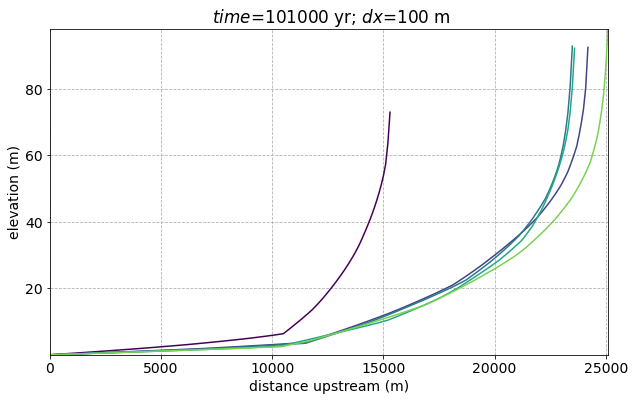

In [19]:
flow__receiver_node = mg.at_node['flow__receiver_node']
indices = np.where(mg.status_at_node[flow__receiver_node] == 0)

#calculated the first five longest 
indices = np.where(mg.status_at_node[flow__receiver_node] == 0)
prf = ChannelProfiler(mg, number_of_watersheds =5,
                     minimum_channel_threshold = dxy**2)
prf.run_one_step()

plt.figure(figsize = (10,6))
title_text = f" $time$={total_time} yr; $dx$={dxy} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)
plt.grid(linestyle='--')
plt.rcParams.update({'font.size':14})

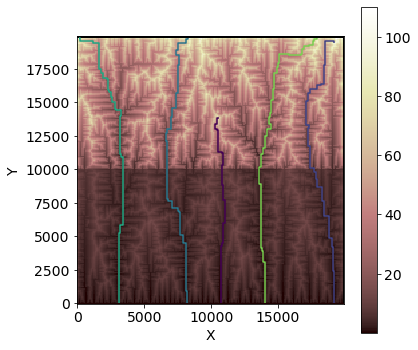

In [10]:
plt.figure(figsize = (6,6))
prf.plot_profiles_in_map_view()

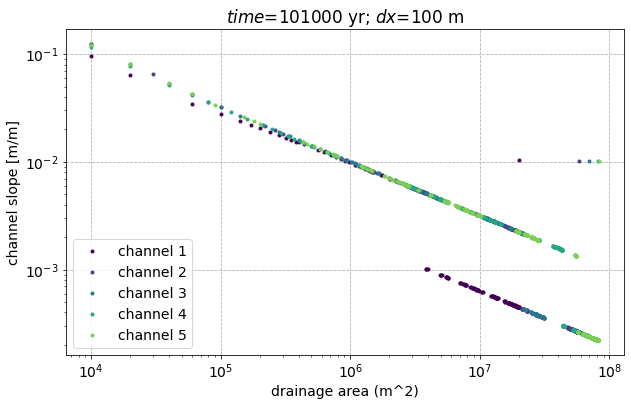

In [16]:
plt.figure(figsize = (10,6))
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg.at_node["drainage_area"][profile_ids],
            mg.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)
plt.grid(linestyle='--')

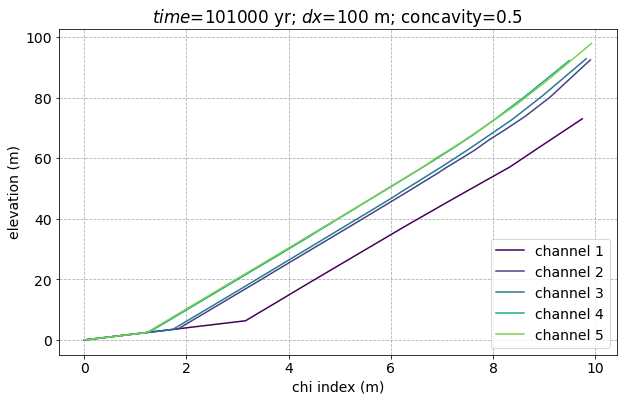

In [17]:
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(figsize = (10,6))

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg.at_node["channel__chi_index"][profile_ids],
            mg.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = f"$time$={total_time} yr; $dx$={dxy} m; concavity={m_sp/n_sp}"
plt.title(title_text)
plt.grid(linestyle='--')

In [13]:
# plt.figure()
# imshow_grid(
#     mg,
#     "channel__chi_index",
#     grid_units=("m", "m"),
#     var_name="Chi index (m)",
#     cmap="jet",
# )
# title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={m_sp/n_sp}"
# plt.title(title_text)


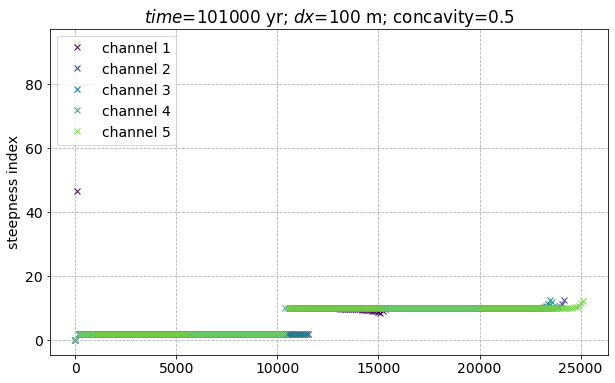

In [18]:
# calculate channel steepness
sf.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(figsize = (10,6))

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg.at_node["channel__steepness_index"][profile_ids],
            'x',
            color=color,
            label=label,
        )

# plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
plt.title(
    f"$time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
)
plt.grid(linestyle='--')

In [15]:
# plt.figure()
# imshow_grid(
#     mg,
#     "channel__steepness_index",
#     grid_units=("m", "m"),
#     var_name="Steepness index ",
#     cmap="jet",
# )
# title_text = ("$K_{sp}$=" + str(K_sp) + "; $time$=" + str(total_time) +
#               "yr; $dx$=" + str(dxy) + "m" + "; concavity=" + str(theta))
# plt.title(
#     f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
# )